## Welcome
This is the notebook from **Zihao Zhou** for Battery.DEV 2022 Challenge II - **BBOX Field Data**  
Our team includes Yannick Kuhn, Srinath Kannou, Nishank Navelkar and Zihao Zhou  



In [57]:
import numpy as np
import pandas as pd 
import warnings

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateFormatter, AutoDateLocator

from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score

## Data Observation

In [2]:
# Load all the .csv files in the data folder (may takes 2-3 minutes)
all_df = pd.read_csv('data/devices1.csv')
for i in range(1,4):
    curr_file_name = 'data/devices' + str(i+1) + '.csv'
    curr_df = pd.read_csv(curr_file_name)
    all_df = pd.concat([all_df, curr_df])

# convert all data into a data set indexed by battery id
max_id = all_df.loc[:,'battery_id'].max()
all_samples = []
for id in range(max_id):
    curr_sample = all_df.groupby('battery_id').get_group(id)
    curr_sample.loc[:,'timestamp'] = pd.to_datetime(curr_sample.loc[:,'timestamp'])
    curr_sample.reset_index(drop=True, inplace=True)
    curr_sample.drop('battery_id',axis=1,inplace=True)
    all_samples.append(curr_sample)

# Let's have a look at cell 0
all_samples[0].head()

C:\Users\sann7383\Anaconda3\envs\pytorchAI\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\sann7383\Anaconda3\envs\pytorchAI\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,battery_voltage,current,current_in,current_out,panel_voltage,state_of_charge_percent,temperature,timestamp,usb_current,voltage
0,7.090,-2.542,2.544,0.002,7.240,NaN,NaN,2021-03-02 06:33:24,0.002,7.185
1,7.100,-2.548,2.550,0.002,7.245,NaN,NaN,2021-03-02 06:35:24,0.002,7.190
2,7.095,-2.472,2.474,0.002,7.275,NaN,NaN,2021-03-02 06:37:24,0.002,7.215
3,7.070,-2.232,2.236,0.004,7.370,NaN,NaN,2021-03-02 06:39:24,0.002,7.290
4,7.075,-2.276,2.278,0.002,7.350,100.0,28.287938,2021-03-02 06:41:24,0.002,7.280


In [3]:
# See what kind of features we have in the data set
print(all_samples[0].columns)
print(len(all_samples))

Index(['battery_voltage', 'current', 'current_in', 'current_out',
       'panel_voltage', 'state_of_charge_percent', 'temperature', 'timestamp',
       'usb_current', 'voltage'],
      dtype='object')
199


We have 200 cells (indexed from 0-199), and the time length is **1 year**  
And the sampling time interval here is **2 minutes**, which means we have $365*24*30 = 262800$ points for each cell each feature curve  
It is hard to directly observe the whole year's data, here, we first take a look on **1 week's** data, that is, **4-5-2021 to 4-12-2021**


In [4]:
# The file 'index_4_5_2021.csv' stored the beginning indexes of 4/5/2021 for every cell
# The required code to generate this file is provided here but commented (*it will takes around 10 minutes to operate)

# judge_list = np.zeros([len(all_samples),1])
# index_list = np.zeros([len(all_samples),1])
# for i in range(len(all_samples)):
#     for ii in range(len(all_samples[i])):
#         years = all_samples[i].loc[:,'timestamp'][ii].year
#         months = all_samples[i].loc[:,'timestamp'][ii].month
#         days = all_samples[i].loc[:,'timestamp'][ii].day
#         if years == 2021 and months == 4 and days == 5:
#             index_list[i] = ii
#             judge_list[i] = 1
#             break
# index_list = index_list.astype(int)
# index_df = pd.Series(index_list.ravel())
# index_df.to_csv('index_4_5_2021.csv')

index_list = pd.read_csv('index_4_5_2021.csv',index_col=0).values
index_list = index_list.astype(int)
dur_time = 7*24*30

**The first idea** here is observing 'temperature' and 'panel_voltage'  
If there exists clear differences among these two kinds of curves, the cells are likely coming from different places  
  
From the visualization for **panel_voltage** and **temperature**,  
we find that these cells share same time periods for sunshine and temperature fluctuation  
So, I conclude that these cells come from a same area, **No Geographical Differences**

Text(0.5, 1.0, 'temperature')

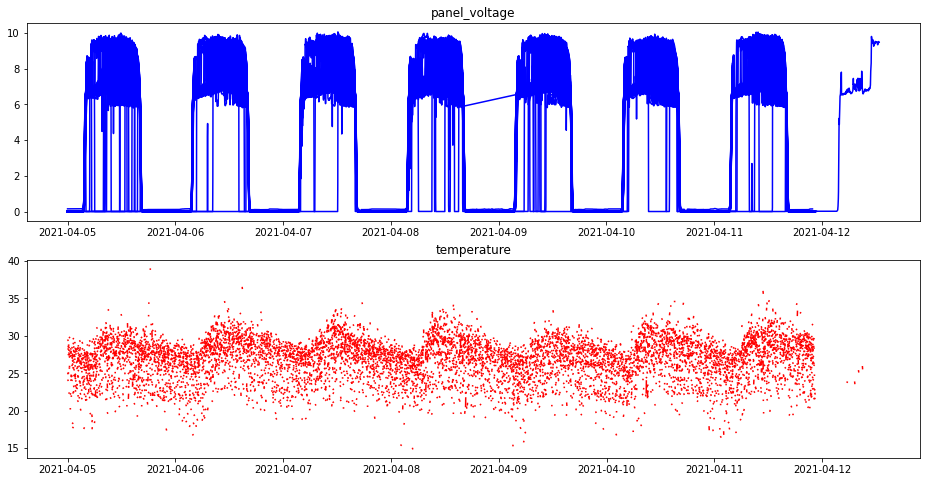

In [5]:
plt.rcParams['figure.figsize'] = [16, 8]
xtick_locator = AutoDateLocator()
xtick_formatter = AutoDateFormatter(xtick_locator)
fig, (ax1,ax2) = plt.subplots(2)

ind = 0
for ind,sample in enumerate(all_samples):
    begin = int(index_list[ind])
    dates = all_samples[ind].loc[begin : begin+dur_time, "timestamp"]
    panel_volt = all_samples[ind].loc[begin : begin+dur_time, "panel_voltage"].values
    temperature = all_samples[ind].loc[begin : begin+dur_time, "temperature"].values
    ax1.plot_date(dates,panel_volt,'b-')
    ax2.plot_date(dates,temperature,'r-')
ax1.set_title('panel_voltage')
ax2.set_title('temperature')

The second idea here is observing **current related features**, they are, **current_out**, **usb_current**  
Here, since our main goal is to clustering cell usage profiles,  
I didnt use **current_in**, which corresponding to input current rather than output for the cell.

From the visualization, I found there exists two level of differences:
1. time level: cells are intensely used in different time periods (details in clustering model section)
2. equipment level: cells are used for powering different equipments.  
There are clear CC-CV current profiles (constant current followed by a exponential decay) which corresponding to charging smartphones. (mainly in 'usb_current')  
There are constant current followed by a instant drop, which corresponding to other non-charging application (for example LED)


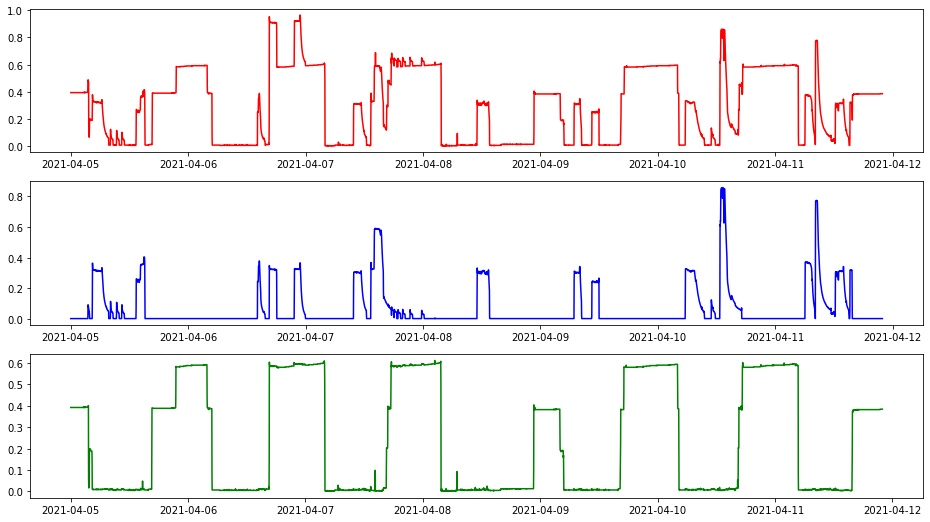

In [6]:
# Basic Visualization for different current features (current_out/usb_current) and different cells (No. 0/10)

plt.rcParams['figure.figsize'] = [16, 9]

fig, (ax1,ax2,ax3) = plt.subplots(3)
dur_time = 7*24*30
ind1,ind2,ind3 = 0,0,10
begin1 = int(index_list[ind1])
begin2 = int(index_list[ind2])
begin3 = int(index_list[ind3])


dates1 = matplotlib.dates.date2num(all_samples[ind1].loc[begin1 : begin1+dur_time, "timestamp"])
current1 = all_samples[ind1].loc[begin1 : begin1+dur_time, "current_out"].values

dates2 = matplotlib.dates.date2num(all_samples[ind2].loc[begin2 : begin2+dur_time, "timestamp"])
current2 = all_samples[ind2].loc[begin2 : begin2+dur_time, "usb_current"].values

dates3 = matplotlib.dates.date2num(all_samples[ind3].loc[begin3 : begin3+dur_time, "timestamp"])
current3 = all_samples[ind3].loc[begin3 : begin3+dur_time, "usb_current"].values

ax1.plot(dates1,current1,'r',label='0')
ax2.plot(dates2,current2,'b',label='10')
ax3.plot(dates3,current1-current2,'g',label='100')

ax1.xaxis.set_major_locator(xtick_locator)
ax1.xaxis.set_major_formatter(xtick_formatter)

ax2.xaxis.set_major_locator(xtick_locator)
ax2.xaxis.set_major_formatter(xtick_formatter)

ax3.xaxis.set_major_locator(xtick_locator)
ax3.xaxis.set_major_formatter(xtick_formatter)

## Cluster Model 1: K-means with Euclidean distance  
Since we have an intuition: there are different usage patterns within current related pattern  
especially, **usb_currnet** and **current_out - usb_current**  
Here, I used an naive K-means model to do the first dirty clustering on these current features.

In [7]:
# Convert all_samples into a ndarray for later usage
dur_time = 1*24*30
week_usb_data = []

for i,index in enumerate(index_list):
    index = int(index)
    curr_data = all_samples[i].loc[index:index+dur_time,'usb_current'].values
    # curr_data = all_samples[i].loc[index:index+dur_time,'current_out'].values - all_samples[i].loc[index:index+dur_time,'usb_current'].values
    week_usb_data.append(curr_data)
week_usb_data = np.asarray(week_usb_data)

In [8]:
# Different cluster numbers are tried ranging from 2 to 8  
# cluster numbers = 4 is used here as an example  
# more sophisticated way to determine cluster number is shown in Parameter Optimization section
from tslearn.clustering import TimeSeriesKMeans
cluster_num = 4

km = TimeSeriesKMeans(n_clusters=cluster_num, metric="euclidean", max_iter=50,
                        random_state=666).fit(week_usb_data)

y_pred = km.predict(week_usb_data)
index0 = int(index_list[0])
(uniques,counts) = np.unique(y_pred, return_counts=True)
date_time =  all_samples[0].loc[index0:index0+dur_time,'timestamp']

C:\Users\sann7383\Anaconda3\envs\pytorchAI\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 199 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


The clustering result on **usb_current** mainly indicates time level differences:  
The usb ports of bpower20 are frequently used for charging purpose  
Cluster 0: heavily used in **_morning (5 am – 2 pm)_**  
Cluster 1: heavily used in **_night (5 pm – 11 pm)_**  
Cluster 2: Not Clear, used equily intense **_during the whole day_**  
Cluster 3: heavily used in **_daytime (9 am – 6 pm)_**  



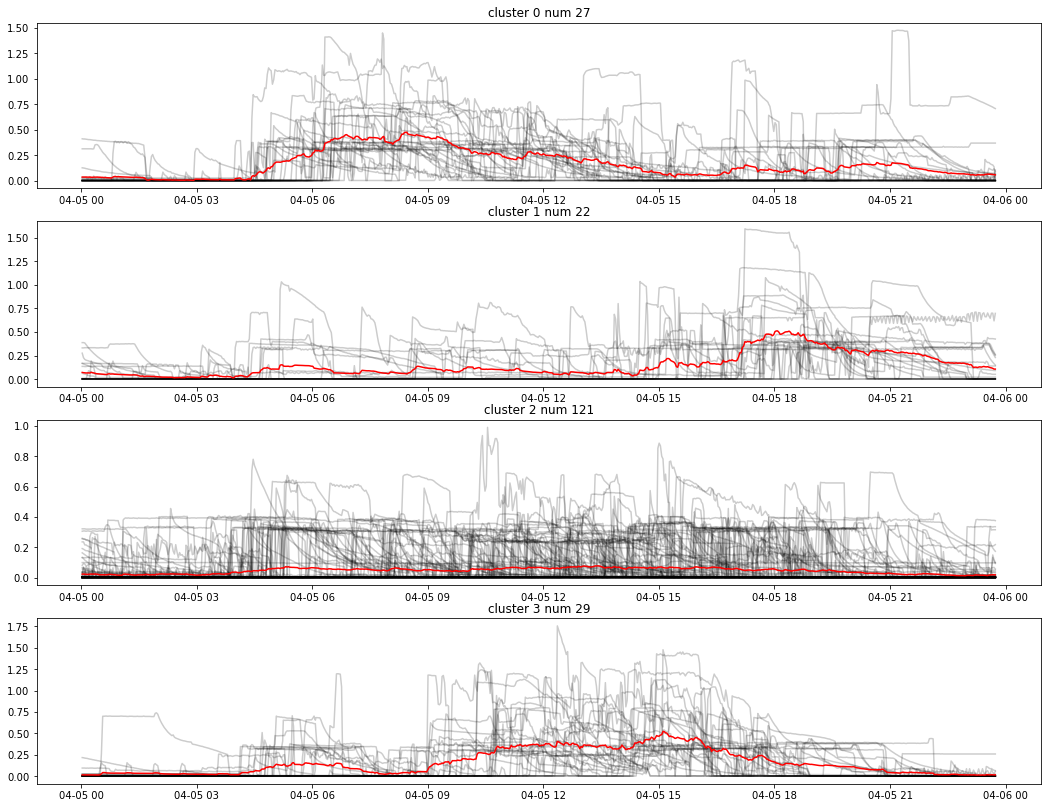

In [9]:
plt.rcParams['figure.figsize'] = [18, 14]
for i in range(cluster_num):
    plt.subplot(cluster_num, 1, i + 1)
    for xx in week_usb_data[y_pred == i]: 
        plt.plot_date(date_time,xx.ravel(), "k-", alpha=.2)
    plt.plot_date(date_time,km.cluster_centers_[i].ravel(), "r-")
    plt.title('cluster '+str(i)+' num '+str(counts[i]))

Also, we may see these differences in time level more clear by averaging current within each hour

In [10]:
# count the average usage during each hour 
week_hourly_data = np.zeros([week_usb_data.shape[0],24])
for i in range(week_usb_data.shape[0]):
    for h in range(24):
        avg_value = np.mean(week_usb_data[i,h*30:(h+1)*30])
        week_hourly_data[i,h] = avg_value

km_hour = TimeSeriesKMeans(n_clusters=cluster_num, metric="euclidean", max_iter=50,
                        random_state=666).fit(week_hourly_data)

y_pred_hour = km_hour.predict(week_hourly_data)
(uniques,counts) = np.unique(y_pred_hour, return_counts=True)
time_hour = np.arange(0,24,1)

C:\Users\sann7383\Anaconda3\envs\pytorchAI\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 199 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


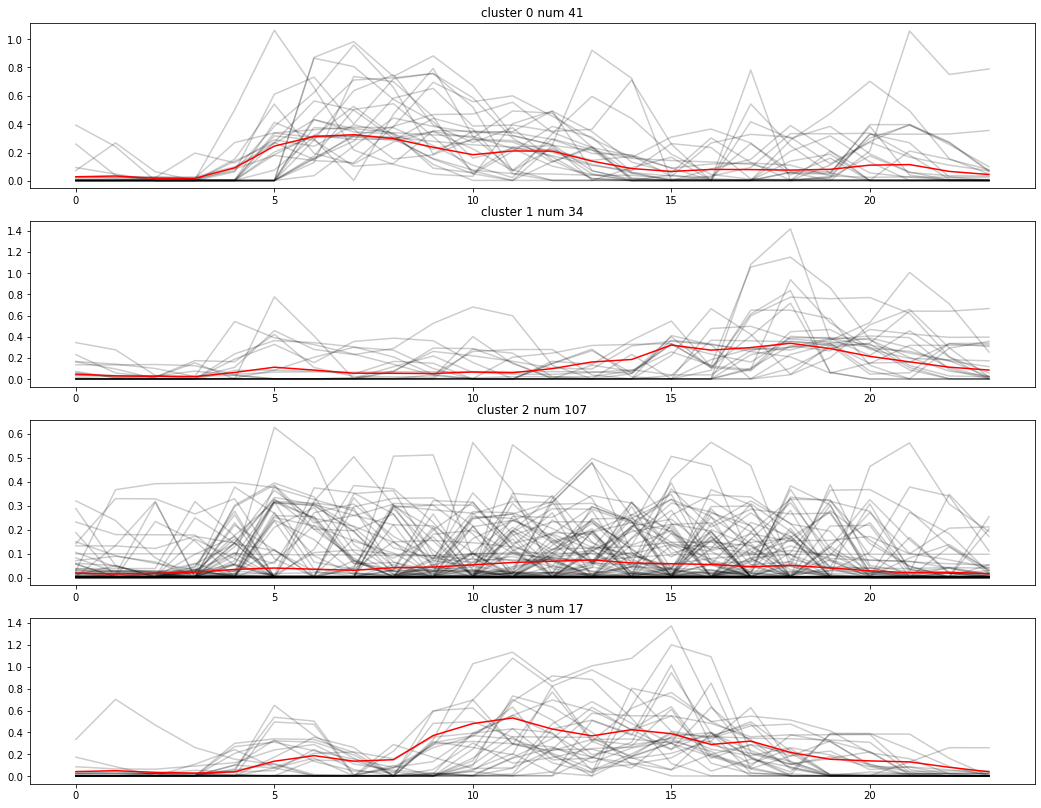

In [11]:
plt.rcParams['figure.figsize'] = [18, 14]
for yi in range(cluster_num):
    plt.subplot(cluster_num, 1, yi + 1)
    for xx in week_hourly_data[y_pred == yi]: 
        plt.plot(time_hour,xx.ravel(), "k-", alpha=.2)
    plt.plot(time_hour,km_hour.cluster_centers_[yi].ravel(), "r-")
    plt.title('cluster '+str(yi)+' num '+str(counts[yi]))

## Visualization by t-SNE  
Here, I use t-SNE to reduce the dimension of usb_current curve  
so that we can plot samples in a 2D figure

However, the boundary between different clusters is not very clear  
maybe because of 2 dimentions are not enough to describe the differences we observed from raw usb_current curve

C:\Users\sann7383\Anaconda3\envs\pytorchAI\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


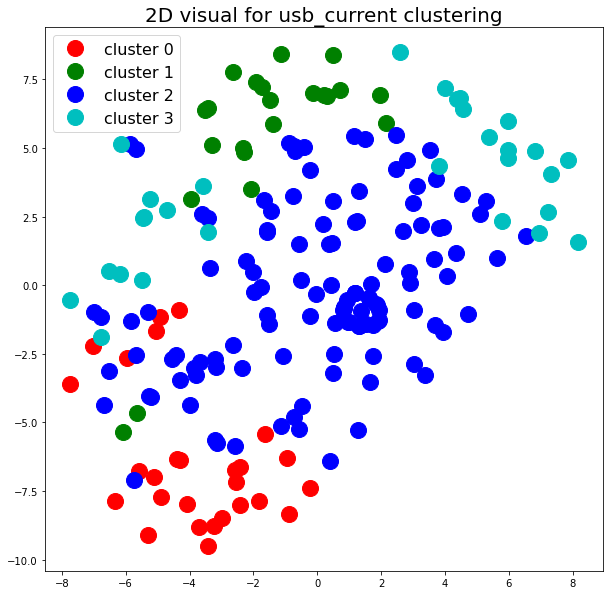

In [13]:
tsne = TSNE(n_components=2, init='pca', random_state=1)
week_usb_data_embedded = TSNE(n_components=2, init='pca',learning_rate='auto').fit_transform(week_usb_data)

plt.rcParams['figure.figsize'] = [10,10]
color_list = ['r','g','b','c']
for i in range(cluster_num):
    curr_samples = np.where(y_pred == i)[0]
    for ind,ii in enumerate(curr_samples):
        if ind == 0:
            plt.plot(week_usb_data_embedded[ii,0],week_usb_data_embedded[ii,1] ,
                    "o", markersize=16, linewidth=1, color=color_list[i], label='cluster '+str(i))
        else:
            plt.plot(week_usb_data_embedded[ii,0],week_usb_data_embedded[ii,1] ,
                    "o", markersize=16, linewidth=1, color=color_list[i])
plt.title('2D visual for usb_current clustering',fontsize = 20)
plt.legend(fontsize=16)



## K-means on (current_out - usb_current) & Visualization

Here, I repeated the process on **current_out - usb_current** curve

In [14]:
dur_time = 7*24*30
week_other_data = []

for i,index in enumerate(index_list):
    index = int(index)
    # curr_data = all_samples[i].loc[index:index+dur_time,'usb_current'].values
    curr_data = all_samples[i].loc[index:index+dur_time,'current_out'].values - all_samples[i].loc[index:index+dur_time,'usb_current'].values
    week_other_data.append(curr_data)
week_other_data = np.asarray(week_other_data)

In [15]:
cluster_num = 4

km = TimeSeriesKMeans(n_clusters=cluster_num, metric="euclidean", max_iter=50,
                        random_state=666).fit(week_other_data)

y_pred = km.predict(week_other_data)
index0 = int(index_list[0])
(uniques,counts) = np.unique(y_pred, return_counts=True)
date_time =  all_samples[0].loc[index0:index0+dur_time,'timestamp']

C:\Users\sann7383\Anaconda3\envs\pytorchAI\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 199 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


The clustering result on **current_out - usb_current** mainly indicates **equipment level differences**:  
The barrel jacks of bpower20 are tensely used almost for same time periods, but for different purposes (required different output current values)  
For cluster 0 & 2, the middle platforms locate on different current values, i.e. **0.2A for cluster 0/ 0.4A for cluster 2**  
For cluster 1, cells are in **rest** except for evening  
For cluster 3, cells are almost **always operating at 0.2A**, with also heavily usage for evening  


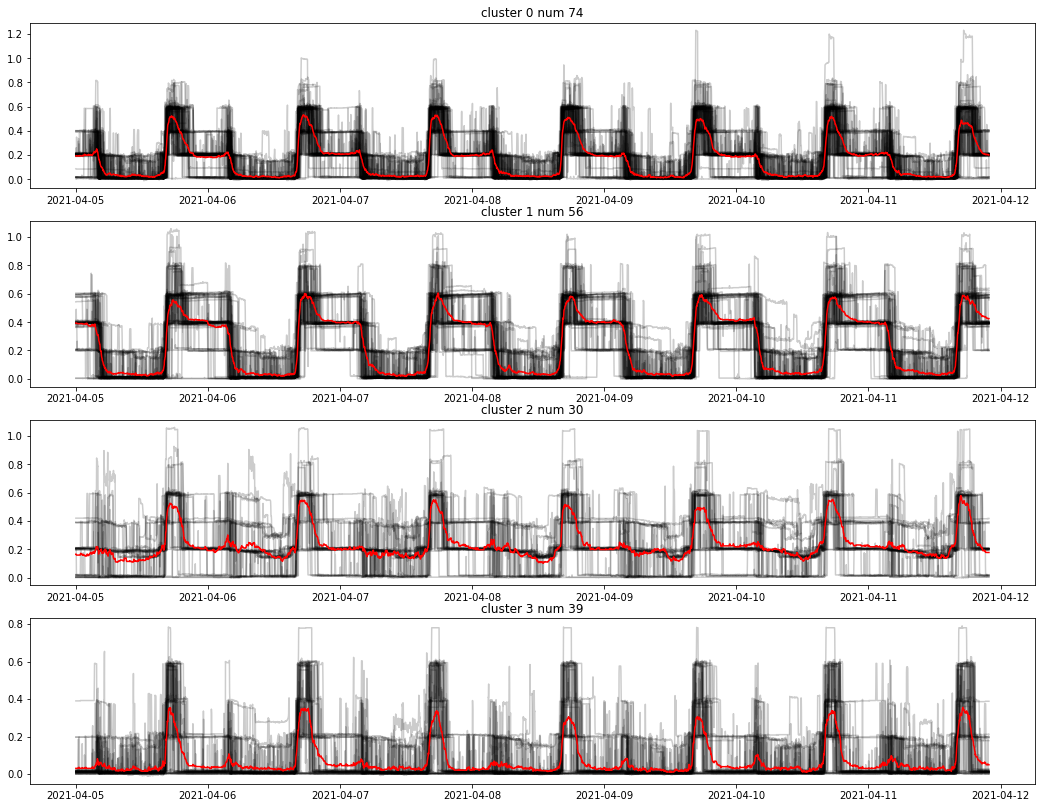

In [16]:
plt.rcParams['figure.figsize'] = [18, 14]
for i in range(cluster_num):
    plt.subplot(cluster_num, 1, i + 1)
    for xx in week_other_data[y_pred == i]: 
        plt.plot_date(date_time,xx.ravel(), "k-", alpha=.2)
    plt.plot_date(date_time,km.cluster_centers_[i].ravel(), "r-")
    plt.title('cluster '+str(i)+' num '+str(counts[i]))

The boundary between different clusters is clear 
which indicates (current_out - usb_current) is a very good feature 

C:\Users\sann7383\Anaconda3\envs\pytorchAI\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


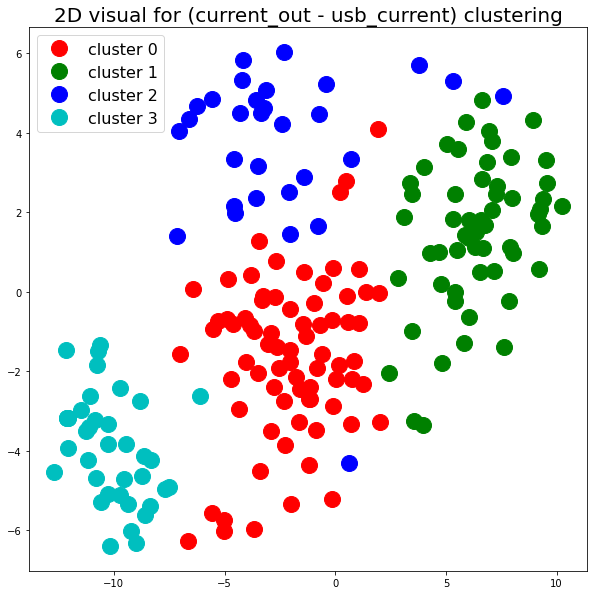

In [18]:
tsne = TSNE(n_components=2, init='pca', random_state=1)
week_other_data_embedded = TSNE(n_components=2, init='pca',learning_rate='auto').fit_transform(week_other_data)

plt.rcParams['figure.figsize'] = [10,10]
color_list = ['r','g','b','c']
for i in range(cluster_num):
    curr_samples = np.where(y_pred == i)[0]
    for ind,ii in enumerate(curr_samples):
        if ind == 0:
            plt.plot(week_other_data_embedded[ii,0],week_other_data_embedded[ii,1] ,
                    "o", markersize=16, linewidth=1, color=color_list[i], label='cluster '+str(i))
        else:
            plt.plot(week_other_data_embedded[ii,0],week_other_data_embedded[ii,1] ,
                    "o", markersize=16, linewidth=1, color=color_list[i])
plt.title('2D visual for (current_out - usb_current) clustering',fontsize = 20)
plt.legend(fontsize=16)


## Parameter Optimization  
Here we use two different categories of methods to decide **cluster number**  
### 1. Metrics based Methods:  
Elbow Rule / Silhouette Coefficient

In [20]:
# Elbow Method runs K-means clustering on a range of values for k (cluster number)
# for each k, compare the average score (sum of distances of samples to their closest center) for all clusters
warnings.filterwarnings("ignore")
cluster_num_range = np.arange(2,9,1)
elbow_usb = np.zeros((1,len(cluster_num_range)))[0]
elbow_other = np.zeros((1,len(cluster_num_range)))[0]
silhoutte_usb = np.zeros((1,len(cluster_num_range)))[0]
silhouette_other = np.zeros((1,len(cluster_num_range)))[0]


for ind,num in enumerate(cluster_num_range):
    km_usb = TimeSeriesKMeans(n_clusters=num, metric="euclidean", max_iter=50,
                        random_state=666).fit(week_usb_data)
    km_other = TimeSeriesKMeans(n_clusters=num, metric="euclidean", max_iter=50,
                        random_state=666).fit(week_other_data)

    pred_usb = km_usb.predict(week_usb_data)                   
    pred_other = km_other.predict(week_other_data)

    elbow_usb[ind] = km_usb.inertia_
    elbow_other[ind] = km_other.inertia_
    silhoutte_usb[ind] = silhouette_score(week_usb_data, pred_usb)
    silhouette_other[ind] = silhouette_score(week_other_data, pred_other)


**Elbow Rule**  
For **'usb_current'** the score curve does not show any shape like elbow  
the sharpest drop exist between $k=1->k=2$.  
For **(curent_out - usb_current)** the score curve has a turning point at $k=4$  

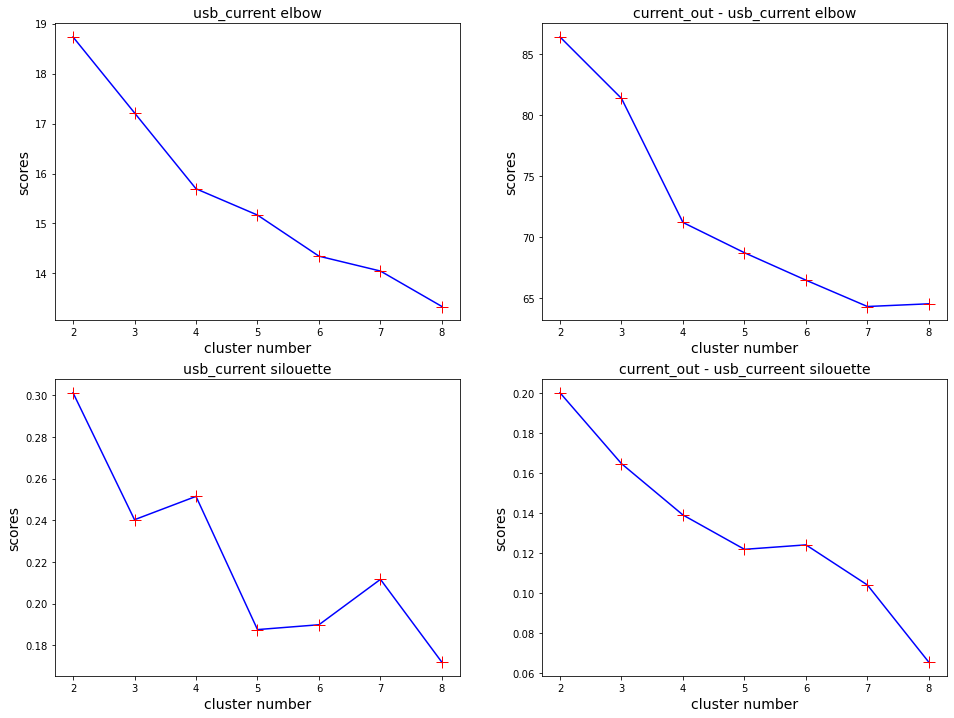

In [39]:
plt.rcParams['figure.figsize'] = [16, 12]
title_list = ['usb_current elbow', 'current_out - usb_current elbow', 'usb_current silouette', 'current_out - usb_curreent silouette']
score_list  = [elbow_usb, elbow_other, silhoutte_usb, silhouette_other]
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(cluster_num_range,score_list[i],'b')
    plt.plot(cluster_num_range,score_list[i],'r+', markersize=12)
    plt.xlabel('cluster number',fontsize =14)
    plt.ylabel('scores',fontsize =14)
    plt.title(title_list[i], fontsize=14)

**Silouette Coefficient** (ranging from -1 to 1, the larger the better) can be calculated for every sample in the data set  
Here, I create a bunch of subfigures:  
Each row represents different number of clusters ranging from 2 to 8 (different colors means different cluster)  
First column is the clustering results for **usb_current**  
Second column is the clustering results for **current_out - usb_current**  
The x-axis represent silouette score, y-axis are cell samples grouped by clusters.
The red lines are average silouette values for all samples.  

The individual silouette coefficients do not show very clear result for **usb_current**  
While for **current_out - usb_current**, it shows, $k=4$ gives larger mean silouette value with most samples have positive silouette values.

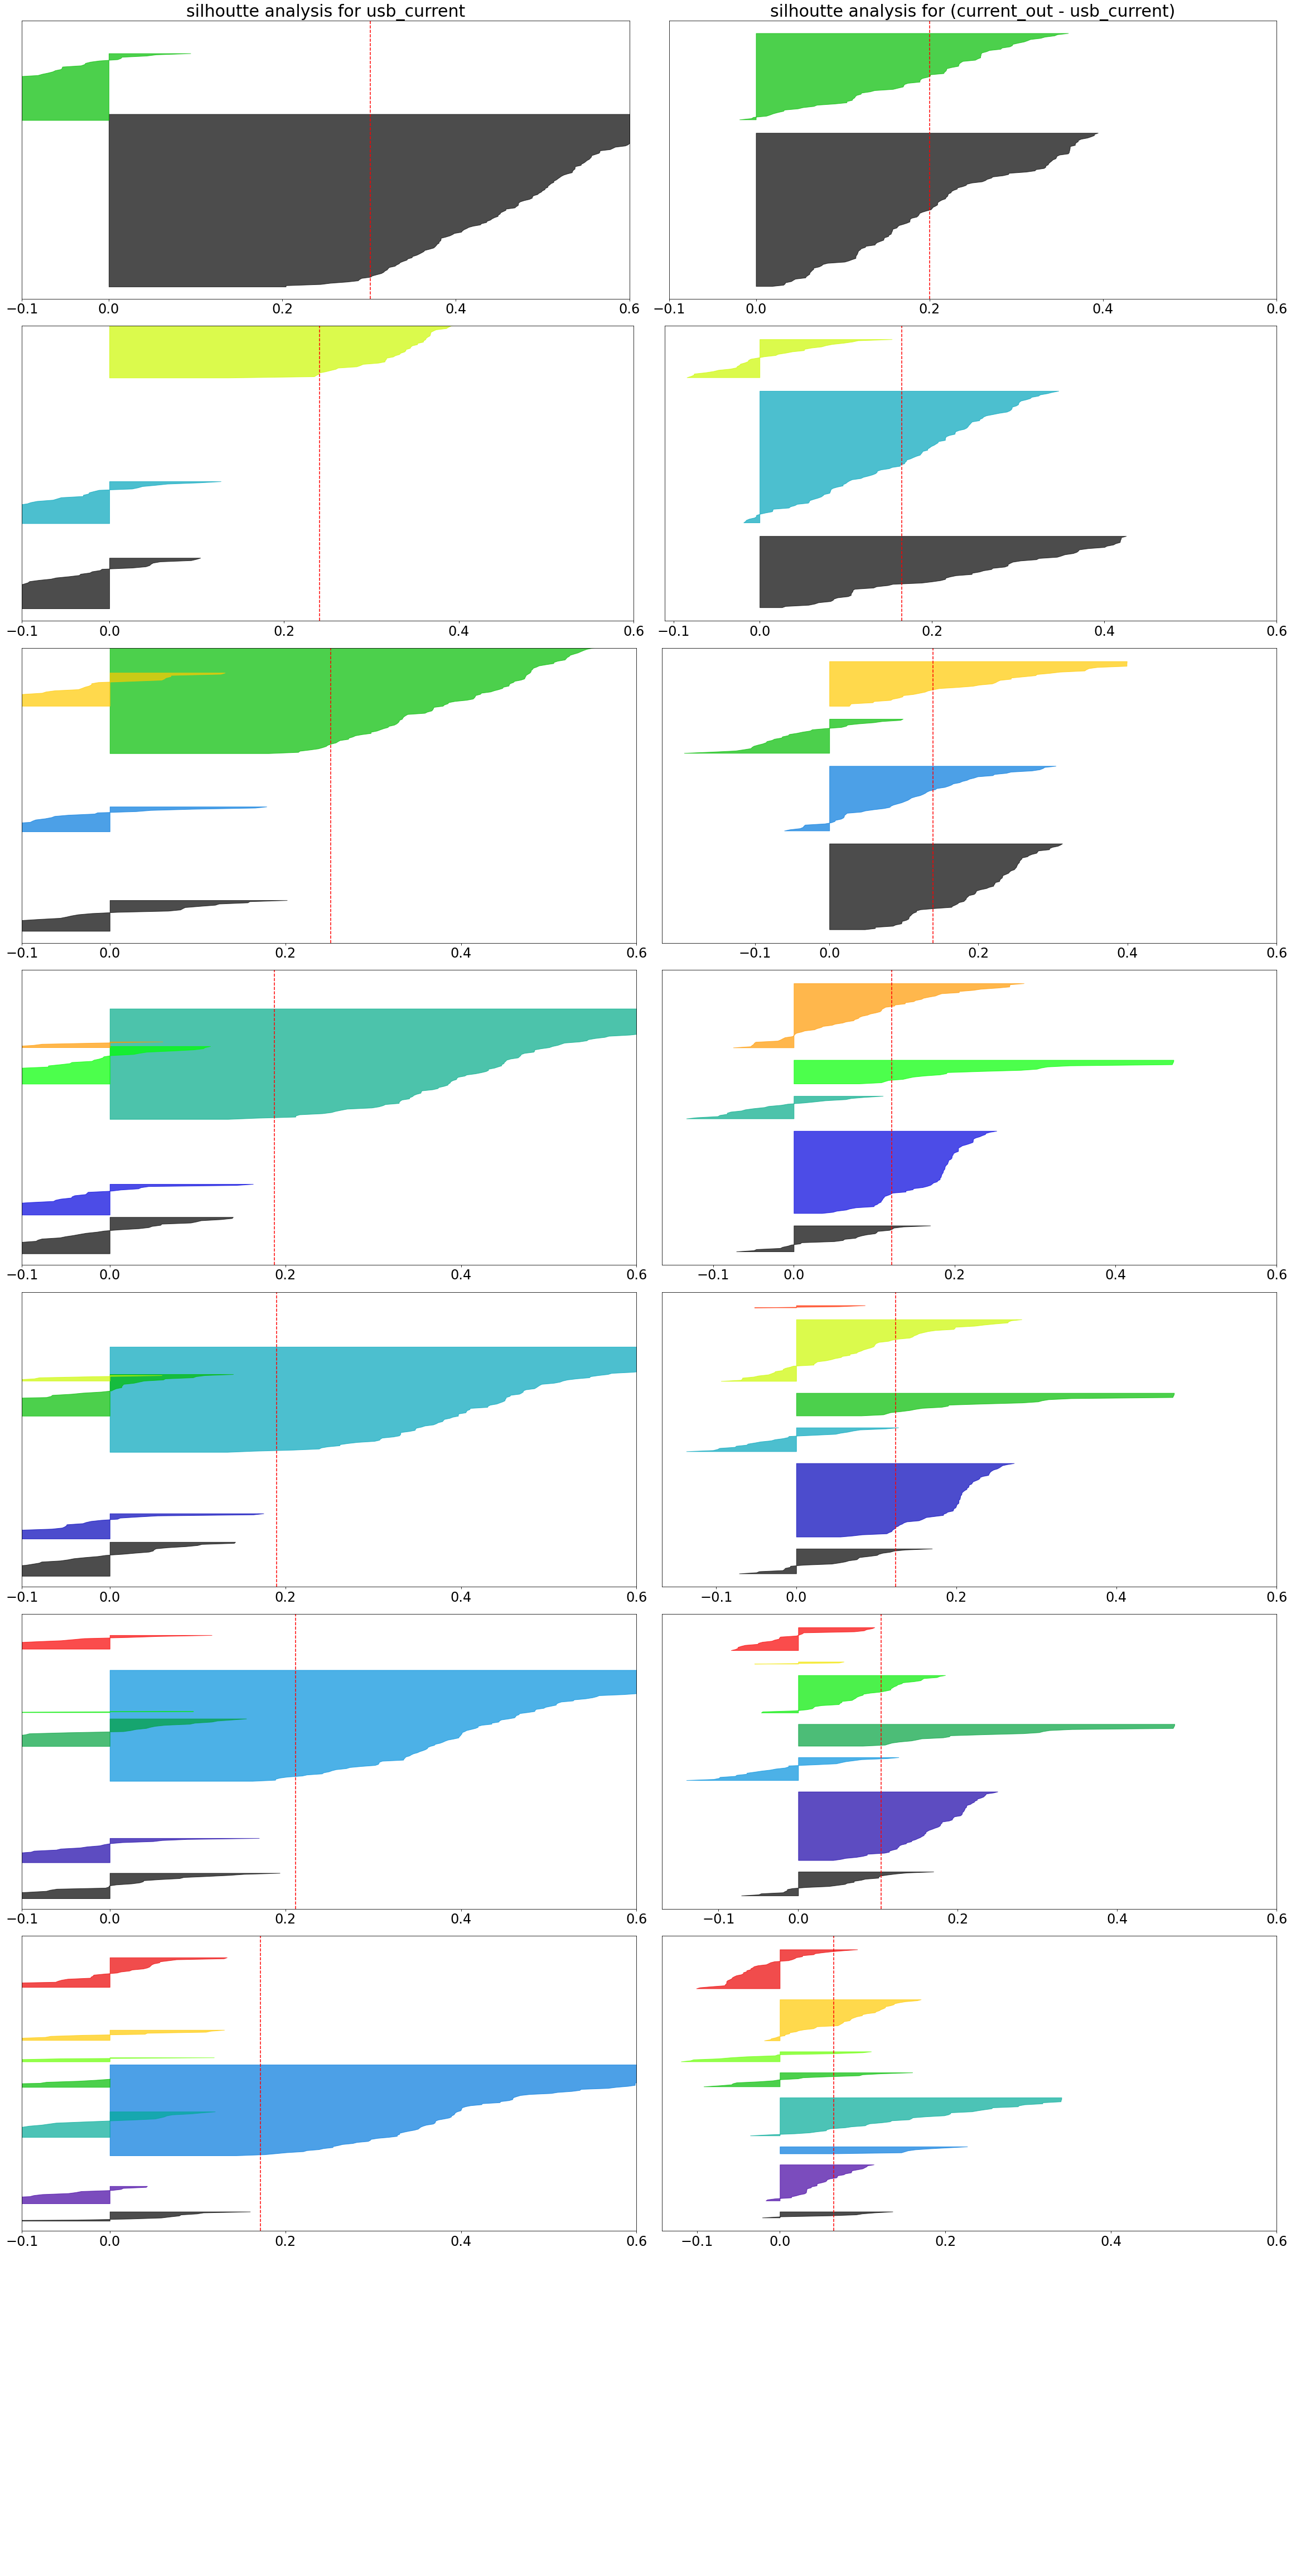

In [35]:
plt.rcParams['figure.figsize'] = [32, 64]
fig = plt.figure(constrained_layout=True)

silhoutte_usb_sample = np.zeros((1,len(cluster_num_range)))[0]
silhoutte_other_sample = np.zeros((1,len(cluster_num_range)))[0]

subfigs = fig.subfigures(8, 1)
for ind,num in enumerate(cluster_num_range):
    
    ax1,ax2 = subfigs[ind].subplots(1,2)
    ax1.set_xlim([-0.1, 0.6])
    ax1.set_ylim([0, len(week_usb_data) + (num + 1) * 10])
    y_lower = 10

    km_usb = TimeSeriesKMeans(n_clusters=num, metric="euclidean", max_iter=50,
                        random_state=666).fit(week_usb_data)
    km_other = TimeSeriesKMeans(n_clusters=num, metric="euclidean", max_iter=50,
                        random_state=666).fit(week_other_data)
    
    pred_usb = km_usb.predict(week_usb_data)                   
    pred_other = km_other.predict(week_other_data)
    silhoutte_usb_sample = silhouette_samples(week_usb_data, pred_usb)
    silhoutte_other_sample = silhouette_samples(week_other_data, pred_other)

    for i in range(num):
        ith_cluster_silhouette_values = silhoutte_usb_sample[pred_usb == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / num)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ith_cluster_silhouette_values = silhoutte_other_sample[pred_other == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / num)
        ax2.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
 
        y_lower = y_upper + 10

    ax1.axvline(x=silhoutte_usb[ind], color="red", linestyle="--")
    ax2.axvline(x=silhouette_other[ind], color="red", linestyle="--")
    ax1.tick_params(labelsize=24)
    ax2.tick_params(labelsize=24)

    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6])
    
    ax2.set_yticks([])  
    ax2.set_xticks([-0.1, 0, 0.2, 0.4, 0.6])
    if ind == 0:
        ax1.set_title('silhoutte analysis for usb_current',fontsize = 30)
        ax2.set_title('silhoutte analysis for (current_out - usb_current)',fontsize = 30)


### 2. Canopy Algorithm (pre-clustering)  
Canopy Algorithm is a pre-clustering method providing initial cluster number and centriods,  
which is often used with k-means to deal with large data sets  

In [58]:
from sklearn.metrics.pairwise import pairwise_distances

def canopy(X, T1, T2, distance_metric='euclidean', filemap=None):
    canopies = dict()
    X1_dist = pairwise_distances(X, metric=distance_metric)
    canopy_points = set(range(X.shape[0]))
    while canopy_points:
        point = canopy_points.pop()
        i = len(canopies)
        canopies[i] = {"c":point, "points": list(np.where(X1_dist[point] < T2)[0])}
        canopy_points = canopy_points.difference(set(np.where(X1_dist[point] < T1)[0]))
    if filemap:
        for canopy_id in canopies.keys():
            canopy = canopies.pop(canopy_id)
            canopy2 = {"c":filemap[canopy['c']], "points":list()}
            for point in canopy['points']:
                canopy2["points"].append(filemap[point])
            canopies[canopy_id] = canopy2
    return canopies

Text(0.5, 0, 'avg_pair_distance_other')

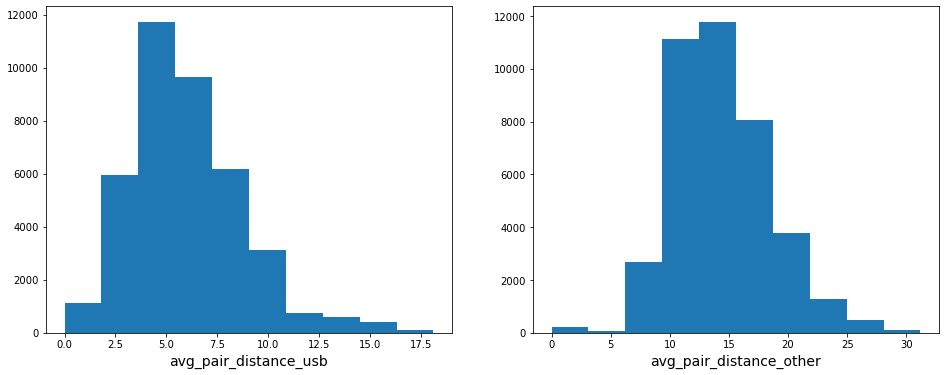

In [59]:
avg_distance_usb = pairwise_distances(week_usb_data)
avg_distance_other = pairwise_distances(week_other_data)
plt.rcParams['figure.figsize'] = [16, 6]
plt.subplot(1,2,1)
plt.hist(avg_distance_usb.ravel())
plt.xlabel('avg_pair_distance_usb',fontsize = 14)
plt.subplot(1,2,2)
plt.hist(avg_distance_other.ravel())
plt.xlabel('avg_pair_distance_other',fontsize = 14)

In [60]:
# The hyper parameters T1 and T2 can be fine-tuning by cross validation
# Generally speaking, they should be set around the average pair distance for all samples  
# The larger of T1, the less number of group it tends to give.
# Here, by trials and error, I set T1 = 1.25*avg_distance and T2 = 0.9*T1
T1_usb = 1.25*np.sum(avg_distance_usb) / (len(avg_distance_usb)*len(avg_distance_usb))
T2_usb = T1_usb*0.9
T1_other = 1.25*np.sum(avg_distance_other) / (len(avg_distance_other)*len(avg_distance_other))
T2_other = T1_other*0.9
canopy_usb = canopy(week_usb_data, T1_usb, T2_usb)
canopy_other = canopy(week_other_data, T1_other, T2_other)

In [61]:
print('usb_current cluster number: ', canopy_usb.keys())
print('current_out - usb_current cluster number: ', canopy_other.keys())

usb_current cluster number:  dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
current_out - usb_current cluster number:  dict_keys([0, 1, 2, 3, 4])


# Conclusion

From observing **panel_voltage** and **temperature**, we found all 200 cells come from same area.  

we have find the usage profiles can be divided by two criteria:  
1. different time periods for usage  (observed from **usb_current**)  
2. different energy consuming equipments (observed from **current_out - usb_current**)  

Then, I used **K-means** based on euclidean for clustering.  
Also, **t-SNE** is used for visualization of the clustering results.  

To determine the cluster number, **elbow rule**, **silhoutte coefficient** and **canopy algorithm** are used.  
Unfortunately, because of the unbalanced sample size for different clusters when using **usb_current**  
All three method didnt give much insight about how many clusters we should divide baed on **usb_current**  
However, for **current_out - usb_current**, the the reasonable cluster number should be **$k=4$**
